In [1]:
import matplotlib.pyplot as plt
from botorch.optim import optimize_acqf
from gpytorch.kernels import RBFKernel,ScaleKernel
from gpytorch.means import ZeroMean
from botorch.models.gp_regression import FixedNoiseGP
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.utils.sampling import manual_seed
import warnings

from botorch.exceptions.warnings import BotorchTensorDimensionWarning, InputDataWarning
warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


warnings.filterwarnings(
            "ignore",
            message="Input data is not standardized.",
            category=InputDataWarning,
        )

/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from known_boundary.GP import optimise,optimise_warp
from known_boundary.utlis import Trans_function, get_initial_points,transform
import numpy as np
import torch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock,Powell
from botorch.utils.transforms import unnormalize,normalize
from botorch.acquisition import qKnowledgeGradient
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition import PosteriorMean
from gpytorch.mlls import ExactMarginalLogLikelihood

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [4]:
fun = Branin(negate=True)
dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
 
n_init = 4*dim
iter_num = 15*dim
exp_num = 100


batch_size = 1
NUM_RESTARTS = 3*dim
RAW_SAMPLES = 30*dim
Num_Fantasies = 2**6

In [8]:
BO_KG = []
torch.set_default_dtype(dtype)

for N in range(20):

    print(N)

    seed = N
    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)


    torch.manual_seed(seed)

    best = Y_BO.max().item()
    best_record = [best]
    
    np.random.seed(1234)

    for i in range(iter_num):  # Run until TuRBO converges
        #print(i)
        # Fit a GP model
        train_yvar = torch.tensor(10**(-5), device=device, dtype=dtype)

        train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
        train_X = normalize(X_BO, bounds)

        train_Y = train_Y.numpy()
        train_X = train_X.numpy()
        
        # train the GP
        res = optimise(train_X,train_Y)


        covar_module = ScaleKernel(RBFKernel())
        model = FixedNoiseGP(torch.tensor(train_X), torch.tensor(train_Y),train_yvar.expand_as(torch.tensor(train_Y)), mean_module = ZeroMean(),covar_module=covar_module)
        
        model.eval()
        
        model.covar_module.base_kernel.lengthscale = torch.sqrt(torch.tensor(res[0]))
        model.covar_module.outputscale = torch.tensor(res[1])

        qKG = qKnowledgeGradient(model, num_fantasies=Num_Fantasies)
        
        # Create a batch
        AF = qKnowledgeGradient(model, num_fantasies=Num_Fantasies).to(device)
        with manual_seed(1234):
            candidates, acq_value = optimize_acqf(
                acq_function=AF,
                bounds=torch.tensor([0.,1.]*dim).reshape(-1,2).T,
                q=batch_size,
                num_restarts=NUM_RESTARTS,
                raw_samples=RAW_SAMPLES,
                #options={'maxiter':50*dim,'maxfun':50*dim,'disp': False},
            )
        
        argmax_pmean, max_pmean = optimize_acqf(
            acq_function=PosteriorMean(model),
            bounds=torch.tensor([0.,1.]*dim).reshape(-1,2).T,
            q=1,
            num_restarts=NUM_RESTARTS, 
            raw_samples=RAW_SAMPLES,
           )
        
        qKG_proper = qKnowledgeGradient(
            model,
            num_fantasies=Num_Fantasies,
            sampler=qKG.sampler,
            current_value=max_pmean,
            
        )

        with manual_seed(1234):
            X_next_normalized, acq_value_proper = optimize_acqf(
                acq_function=qKG_proper,
                bounds=torch.tensor([0.,1.]*dim).reshape(-1,2).T,
                q=1,
                num_restarts=NUM_RESTARTS,
                raw_samples=RAW_SAMPLES,
               # options={'maxiter':50*dim,'maxfun':50*dim,'disp': False}
    )

        print('this is: ',fun(argmax_pmean))

        X_next = unnormalize(X_next_normalized, bounds)
        Y_next = torch.tensor(
            [fun(x) for x in X_next], dtype=dtype, device=device
        ).reshape(-1,1)

        # Append data
        X_BO = torch.cat((X_BO, X_next), dim=0)
        Y_BO = torch.cat((Y_BO, Y_next), dim=0)

        best_record.append(Y_BO.max().item())
        print(best_record[-1])
        
    best_record = np.array(best_record)    
    BO_KG.append(best_record)

0
this is:  tensor([-41.5435])
-3.5451956715421797
this is:  tensor([-44.3638])
-3.5451956715421797
this is:  tensor([-45.0022])
-3.5451956715421797
this is:  tensor([-43.3756])
-3.5451956715421797
this is:  tensor([-43.8947])
-3.5451956715421797
this is:  tensor([-43.8425])
-3.5451956715421797
this is:  tensor([-43.7348])
-1.929628698513282
this is:  tensor([-43.6655])
-1.3897188059135797
this is:  tensor([-43.6919])
-1.3897188059135797
this is:  tensor([-35.7782])
-1.3897188059135797
this is:  tensor([-35.7782])
-1.3897188059135797
this is:  tensor([-43.7013])
-1.3897188059135797
this is:  tensor([-33.6877])
-0.9733352613156327
this is:  tensor([-34.0201])
-0.9733352613156327
this is:  tensor([-34.4962])
-0.9733352613156327
this is:  tensor([-34.4918])
-0.5775597387012823
this is:  tensor([-35.0597])
-0.5775597387012823
this is:  tensor([-35.0647])
-0.5775597387012823
this is:  tensor([-35.0656])
-0.5775597387012823
this is:  tensor([-35.0441])
-0.5775597387012823
this is:  tensor([-

KeyboardInterrupt: 

In [22]:
fun(argmax_pmean)

tensor([-43.5116])

In [12]:
np.savetxt('exp_res2/Beale2D_GP+KG', BO_KG, delimiter=',')

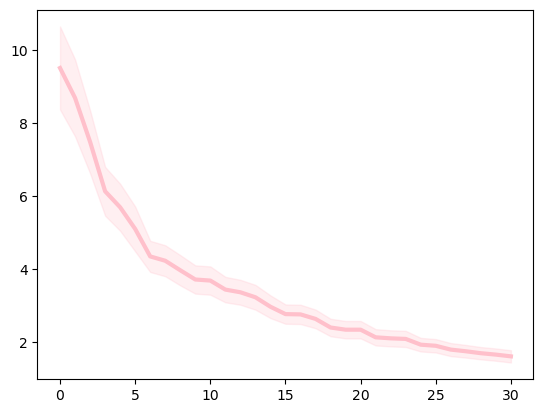

In [13]:
total_record = (-np.array(BO_KG))
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+KG',color='pink')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='pink')